# Exercise 4: Variational Autoencoder (VAE) Implementation

**Student Name:** [Your Name Here]

**Date:** [Date]

## Objective
Implement and evaluate a Variational Autoencoder (VAE) on the MNIST/Fashion MNIST dataset to understand the architecture, training process, and performance of VAEs.

## Table of Contents
1. [Data Preparation](#data-preparation)
2. [Model Implementation](#model-implementation)
3. [Training](#training)
4. [Evaluation](#evaluation)
5. [Visualization](#visualization)
6. [Report](#report)
7. [Extra Credit (Optional)](#extra-credit)

## 1. Data Preparation <a name="data-preparation"></a>

In [33]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Force CPU usage (no CUDA)
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [34]:
# Configuration
# Change DATASET to 'MNIST' or 'FashionMNIST'
DATASET = 'MNIST'  # or 'FashionMNIST'
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
IMAGE_SIZE = 28 * 28  # 784 for MNIST

print(f"Dataset: {DATASET}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Validation split: {VALIDATION_SPLIT}")

Dataset: MNIST
Batch size: 128
Validation split: 0.2


In [35]:
# Load dataset
# Data will be normalized to [0, 1] range
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range automatically
])

# Download and load the training data
if DATASET == 'MNIST':
    full_train_dataset = datasets.MNIST(
        root='../data',
        train=True,
        download=True,
        transform=transform
    )
    test_dataset = datasets.MNIST(
        root='../data',
        train=False,
        download=True,
        transform=transform
    )
else:  # FashionMNIST
    full_train_dataset = datasets.FashionMNIST(
        root='../data',
        train=True,
        download=True,
        transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root='../data',
        train=False,
        download=True,
        transform=transform
    )

print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Full training dataset size: 60000
Test dataset size: 10000


In [36]:
# Split training data into train and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Training set size: 48000
Validation set size: 12000


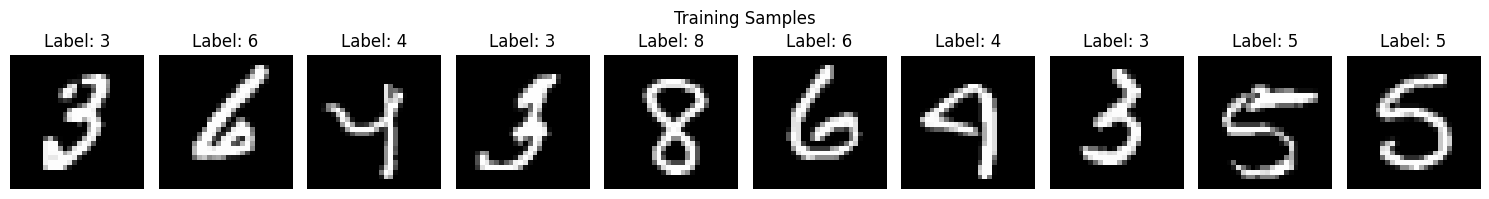

In [37]:
# Visualize some samples from the dataset
def visualize_samples(dataset, n_samples=10, title="Sample Images"):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 2))
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        if hasattr(dataset, 'dataset'):  # For Subset objects
            image, label = dataset.dataset[dataset.indices[idx]]
        else:
            image, label = dataset[idx]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, title="Training Samples")

## 2. Model Implementation <a name="model-implementation"></a>

### VAE Architecture Overview

A Variational Autoencoder consists of:
1. **Encoder**: Maps input $x$ to latent distribution parameters $\mu$ and $\log\sigma^2$
2. **Reparameterization Trick**: Samples $z = \mu + \sigma \odot \epsilon$ where $\epsilon \sim \mathcal{N}(0, I)$
3. **Decoder**: Reconstructs input from latent sample $z$

### Loss Function

VAE loss = Reconstruction Loss + KL Divergence Loss

$$\mathcal{L} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) || p(z))$$

Where:
- Reconstruction Loss: Binary Cross Entropy (BCE) or Mean Squared Error (MSE)
- KL Divergence: $-0.5 \sum (1 + \log\sigma^2 - \mu^2 - \sigma^2)$

In [38]:
# VAE Model Configuration
LATENT_DIM = 2  # Dimension of latent space (start with 2 for easy visualization)
HIDDEN_DIM = 400  # Hidden layer dimension

print(f"Latent dimension: {LATENT_DIM}")
print(f"Hidden dimension: {HIDDEN_DIM}")

Latent dimension: 2
Hidden dimension: 400


In [39]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE)
    
    Architecture:
    - Encoder: input -> hidden -> (mu, log_var)
    - Decoder: latent -> hidden -> output
    """
    
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        # Maps input to hidden representation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Maps hidden to mean (mu) of latent distribution
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        
        # Maps hidden to log variance (log_var) of latent distribution
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layers
        # Maps latent to hidden representation
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        
        # Maps hidden to reconstructed output
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """
        Encoder: Maps input to latent distribution parameters
        
        Args:
            x: Input tensor of shape (batch_size, input_dim)
            
        Returns:
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
        """
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick: z = mu + sigma * epsilon
        where epsilon ~ N(0, 1)
        
        This allows gradients to flow through the sampling process.
        
        Args:
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
            
        Returns:
            z: Sampled latent vector
        """
        # Standard deviation
        std = torch.exp(0.5 * log_var)
        
        # Sample epsilon from standard normal distribution
        epsilon = torch.randn_like(std)
        
        # Reparameterization: z = mu + sigma * epsilon
        z = mu + std * epsilon
        return z
    
    def decode(self, z):
        """
        Decoder: Maps latent representation to reconstructed output
        
        Args:
            z: Latent vector of shape (batch_size, latent_dim)
            
        Returns:
            reconstruction: Reconstructed output
        """
        h = F.relu(self.fc3(z))
        reconstruction = torch.sigmoid(self.fc4(h))
        return reconstruction
    
    def forward(self, x):
        """
        Forward pass through VAE
        
        Args:
            x: Input tensor
            
        Returns:
            reconstruction: Reconstructed output
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

# Initialize model
model = VAE(input_dim=IMAGE_SIZE, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
model = model.to(device)

print("VAE Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

VAE Model Architecture:
VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

Total parameters: 631188


In [40]:
def vae_loss(reconstruction, x, mu, log_var, beta=1.0):
    """
    VAE loss function: Reconstruction loss + KL divergence
    
    Args:
        reconstruction: Reconstructed output from decoder
        x: Original input
        mu: Mean of latent distribution
        log_var: Log variance of latent distribution
        beta: Weight for KL divergence term (beta-VAE)
        
    Returns:
        total_loss: Combined loss
        recon_loss: Reconstruction loss component
        kld_loss: KL divergence loss component
    """
    # Reconstruction loss (Binary Cross Entropy)
    # Measures how well the decoder reconstructs the input
    recon_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    
    # KL Divergence loss
    # Measures how much the learned latent distribution differs from standard normal
    # KL(q(z|x) || p(z)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kld_loss
    
    return total_loss, recon_loss, kld_loss

## 3. Training <a name="training"></a>

In [41]:
# Training configuration
EPOCHS = 50
LEARNING_RATE = 1e-3
BETA = 1.0  # Weight for KL divergence (beta-VAE parameter)

print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Beta (KL weight): {BETA}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Epochs: 50
Learning rate: 0.001
Beta (KL weight): 1.0


In [42]:
def train_epoch(model, train_loader, optimizer, device, beta=1.0):
    """
    Train the VAE for one epoch
    
    Returns:
        avg_loss: Average total loss
        avg_recon_loss: Average reconstruction loss
        avg_kld_loss: Average KL divergence loss
    """
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        # Flatten images and move to device
        data = data.view(-1, IMAGE_SIZE).to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        reconstruction, mu, log_var = model(data)
        
        # Compute loss
        loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, log_var, beta)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate losses
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kld_loss += kld_loss.item()
    
    # Calculate average losses
    n_samples = len(train_loader.dataset)
    avg_loss = total_loss / n_samples
    avg_recon_loss = total_recon_loss / n_samples
    avg_kld_loss = total_kld_loss / n_samples
    
    return avg_loss, avg_recon_loss, avg_kld_loss


def validate_epoch(model, val_loader, device, beta=1.0):
    """
    Validate the VAE on validation set
    
    Returns:
        avg_loss: Average total loss
        avg_recon_loss: Average reconstruction loss
        avg_kld_loss: Average KL divergence loss
    """
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            # Flatten images and move to device
            data = data.view(-1, IMAGE_SIZE).to(device)
            
            # Forward pass
            reconstruction, mu, log_var = model(data)
            
            # Compute loss
            loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, log_var, beta)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kld_loss += kld_loss.item()
    
    # Calculate average losses
    n_samples = len(val_loader.dataset)
    avg_loss = total_loss / n_samples
    avg_recon_loss = total_recon_loss / n_samples
    avg_kld_loss = total_kld_loss / n_samples
    
    return avg_loss, avg_recon_loss, avg_kld_loss

In [43]:
# Training loop
history = {
    'train_loss': [],
    'train_recon_loss': [],
    'train_kld_loss': [],
    'val_loss': [],
    'val_recon_loss': [],
    'val_kld_loss': []
}

print("Starting training...\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_recon, train_kld = train_epoch(
        model, train_loader, optimizer, device, BETA
    )
    
    # Validate
    val_loss, val_recon, val_kld = validate_epoch(
        model, val_loader, device, BETA
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_recon_loss'].append(train_recon)
    history['train_kld_loss'].append(train_kld)
    history['val_loss'].append(val_loss)
    history['val_recon_loss'].append(val_recon)
    history['val_kld_loss'].append(val_kld)
    
    # Print progress
    print(f"Epoch {epoch}/{EPOCHS}:")
    print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KLD: {train_kld:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KLD: {val_kld:.4f}")
    print()

print("Training complete!")

Starting training...

Epoch 1/50:
  Train - Loss: 195.4032, Recon: 189.5694, KLD: 5.8337
  Val   - Loss: 174.1781, Recon: 169.0405, KLD: 5.1377

Epoch 2/50:
  Train - Loss: 170.2989, Recon: 165.2761, KLD: 5.0228
  Val   - Loss: 166.8697, Recon: 161.8110, KLD: 5.0587

Epoch 3/50:
  Train - Loss: 165.6133, Recon: 160.4810, KLD: 5.1324
  Val   - Loss: 163.9083, Recon: 158.8418, KLD: 5.0665

Epoch 4/50:
  Train - Loss: 163.1548, Recon: 157.9277, KLD: 5.2270
  Val   - Loss: 161.9852, Recon: 156.7177, KLD: 5.2675

Epoch 5/50:
  Train - Loss: 161.4777, Recon: 156.1594, KLD: 5.3183
  Val   - Loss: 160.9486, Recon: 155.3208, KLD: 5.6278

Epoch 6/50:
  Train - Loss: 160.2404, Recon: 154.8520, KLD: 5.3883
  Val   - Loss: 159.8600, Recon: 154.4198, KLD: 5.4402

Epoch 7/50:
  Train - Loss: 159.1504, Recon: 153.7048, KLD: 5.4456
  Val   - Loss: 158.9630, Recon: 153.5643, KLD: 5.3987

Epoch 8/50:
  Train - Loss: 158.1160, Recon: 152.6029, KLD: 5.5131
  Val   - Loss: 157.9410, Recon: 152.4430, KLD: 5.

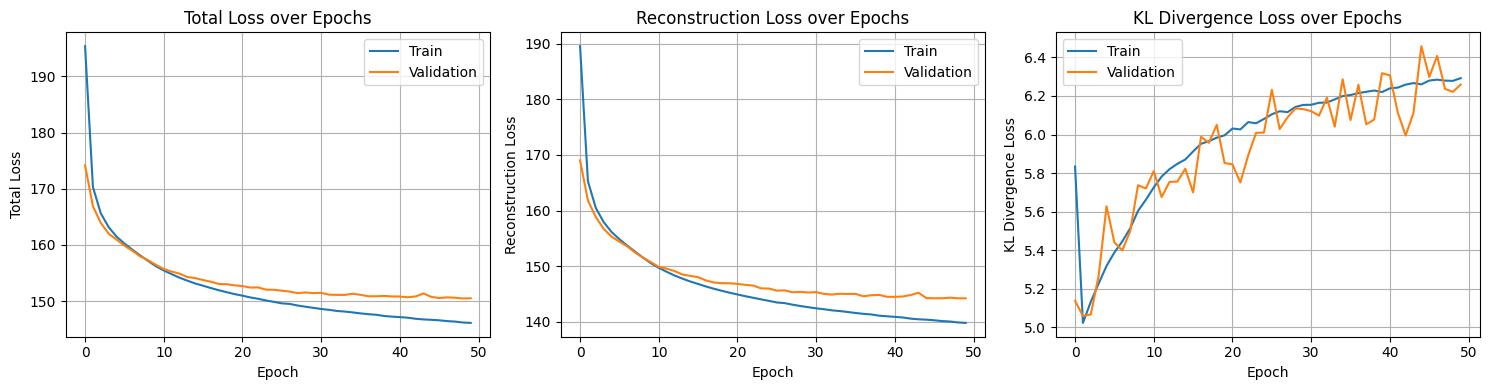

In [44]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('Total Loss over Epochs')
axes[0].legend()
axes[0].grid(True)

# Reconstruction loss
axes[1].plot(history['train_recon_loss'], label='Train')
axes[1].plot(history['val_recon_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss over Epochs')
axes[1].legend()
axes[1].grid(True)

# KL divergence loss
axes[2].plot(history['train_kld_loss'], label='Train')
axes[2].plot(history['val_kld_loss'], label='Validation')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence Loss')
axes[2].set_title('KL Divergence Loss over Epochs')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 4. Evaluation <a name="evaluation"></a>

In [45]:
# Evaluate on test set
test_loss, test_recon, test_kld = validate_epoch(
    model, test_loader, device, BETA
)

print("Test Set Performance:")
print(f"  Total Loss: {test_loss:.4f}")
print(f"  Reconstruction Loss: {test_recon:.4f}")
print(f"  KL Divergence Loss: {test_kld:.4f}")

Test Set Performance:
  Total Loss: 150.1864
  Reconstruction Loss: 143.9659
  KL Divergence Loss: 6.2205


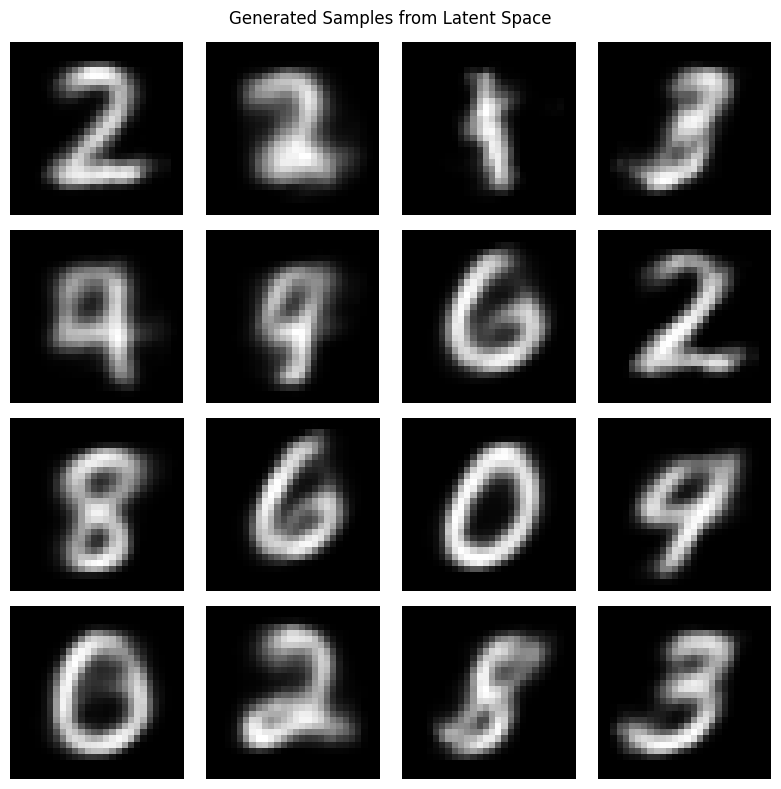

In [46]:
def generate_samples(model, n_samples=16, device='cpu'):
    """
    Generate new samples from the learned latent space
    by sampling from a standard normal distribution
    
    Args:
        model: Trained VAE model
        n_samples: Number of samples to generate
        device: Device to use
        
    Returns:
        Generated images
    """
    model.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device)
        
        # Decode to generate images
        samples = model.decode(z)
        
        # Reshape to image format
        samples = samples.view(n_samples, 1, 28, 28)
        
    return samples.cpu()


# Generate and display samples
n_samples = 16
generated_samples = generate_samples(model, n_samples, device)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated Samples from Latent Space')
plt.tight_layout()
plt.show()

## 5. Visualization <a name="visualization"></a>

### 5.1 Original vs Reconstructed Images

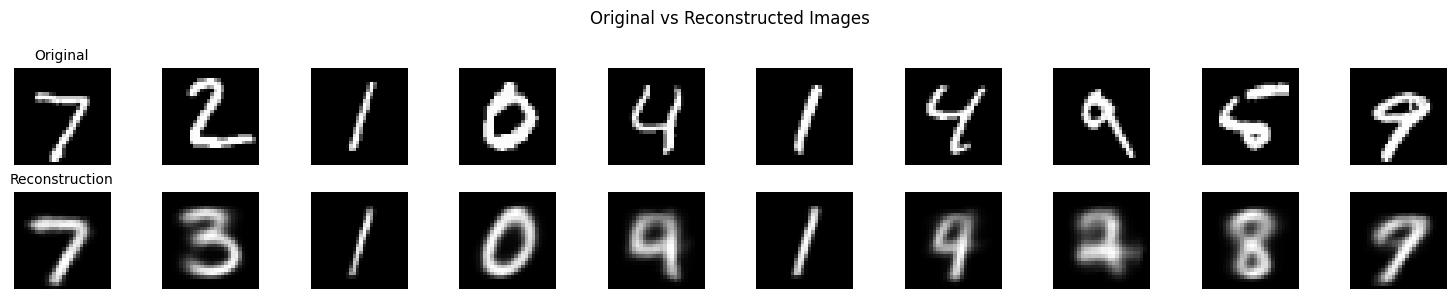

In [47]:
def visualize_reconstructions(model, data_loader, n_samples=10, device='cpu'):
    """
    Visualize original images and their reconstructions
    """
    model.eval()
    
    # Get a batch of data
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:n_samples]
    
    # Flatten and move to device
    images_flat = images.view(n_samples, -1).to(device)
    
    # Get reconstructions
    with torch.no_grad():
        reconstructions, _, _ = model(images_flat)
        reconstructions = reconstructions.view(n_samples, 1, 28, 28)
    
    # Plot
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 3))
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstruction', fontsize=10)
    
    plt.suptitle('Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

visualize_reconstructions(model, test_loader, n_samples=10, device=device)

### 5.2 Latent Space Visualization

In [48]:
def get_latent_representations(model, data_loader, device='cpu', max_samples=5000):
    """
    Get latent representations for all data in the loader
    
    Returns:
        latents: Latent representations (mu)
        labels: Corresponding labels
    """
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        count = 0
        for data, labels in data_loader:
            if count >= max_samples:
                break
            
            # Flatten and move to device
            data = data.view(-1, IMAGE_SIZE).to(device)
            
            # Encode
            mu, _ = model.encode(data)
            
            latents.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
            
            count += len(data)
    
    latents = np.concatenate(latents, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    return latents, labels_list

# Get latent representations
print("Extracting latent representations...")
latents, labels = get_latent_representations(model, test_loader, device)
print(f"Latent space shape: {latents.shape}")

Extracting latent representations...
Latent space shape: (5120, 2)


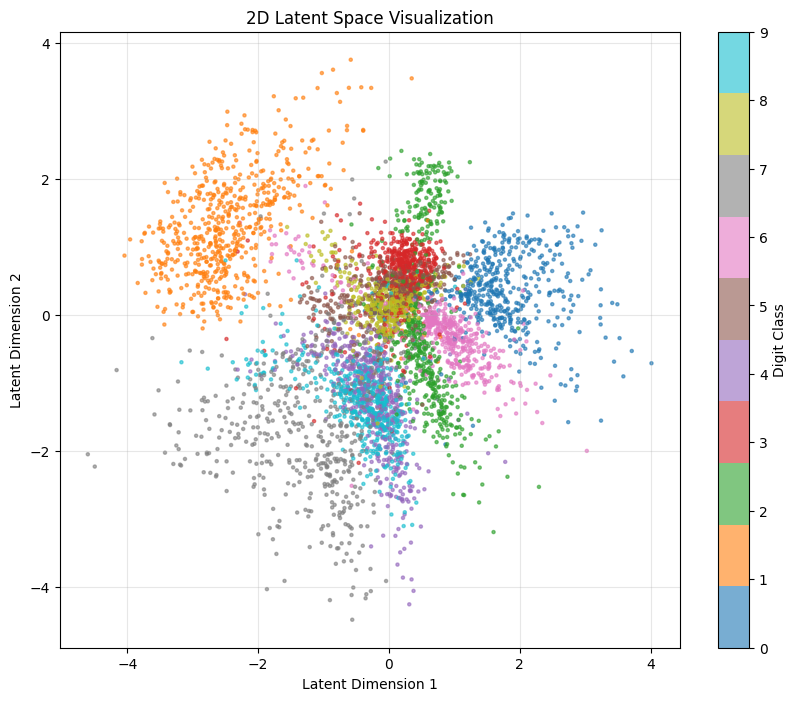

In [49]:
# Visualize latent space
if LATENT_DIM == 2:
    # Direct 2D visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('2D Latent Space Visualization')
    plt.grid(True, alpha=0.3)
    plt.show()
    
elif LATENT_DIM == 3:
    # Direct 3D visualization
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], 
                        c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')
    ax.set_title('3D Latent Space Visualization')
    plt.show()
    
else:
    # Use dimensionality reduction for higher dimensions
    print(f"Latent dimension is {LATENT_DIM}. Using dimensionality reduction...")
    
    # t-SNE visualization
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_tsne = tsne.fit_transform(latents)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of {LATENT_DIM}D Latent Space')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # PCA visualization
    print("Computing PCA...")
    pca = PCA(n_components=2)
    latents_pca = pca.fit_transform(latents)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_pca[:, 0], latents_pca[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'PCA Visualization of {LATENT_DIM}D Latent Space')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Generating latent space manifold...


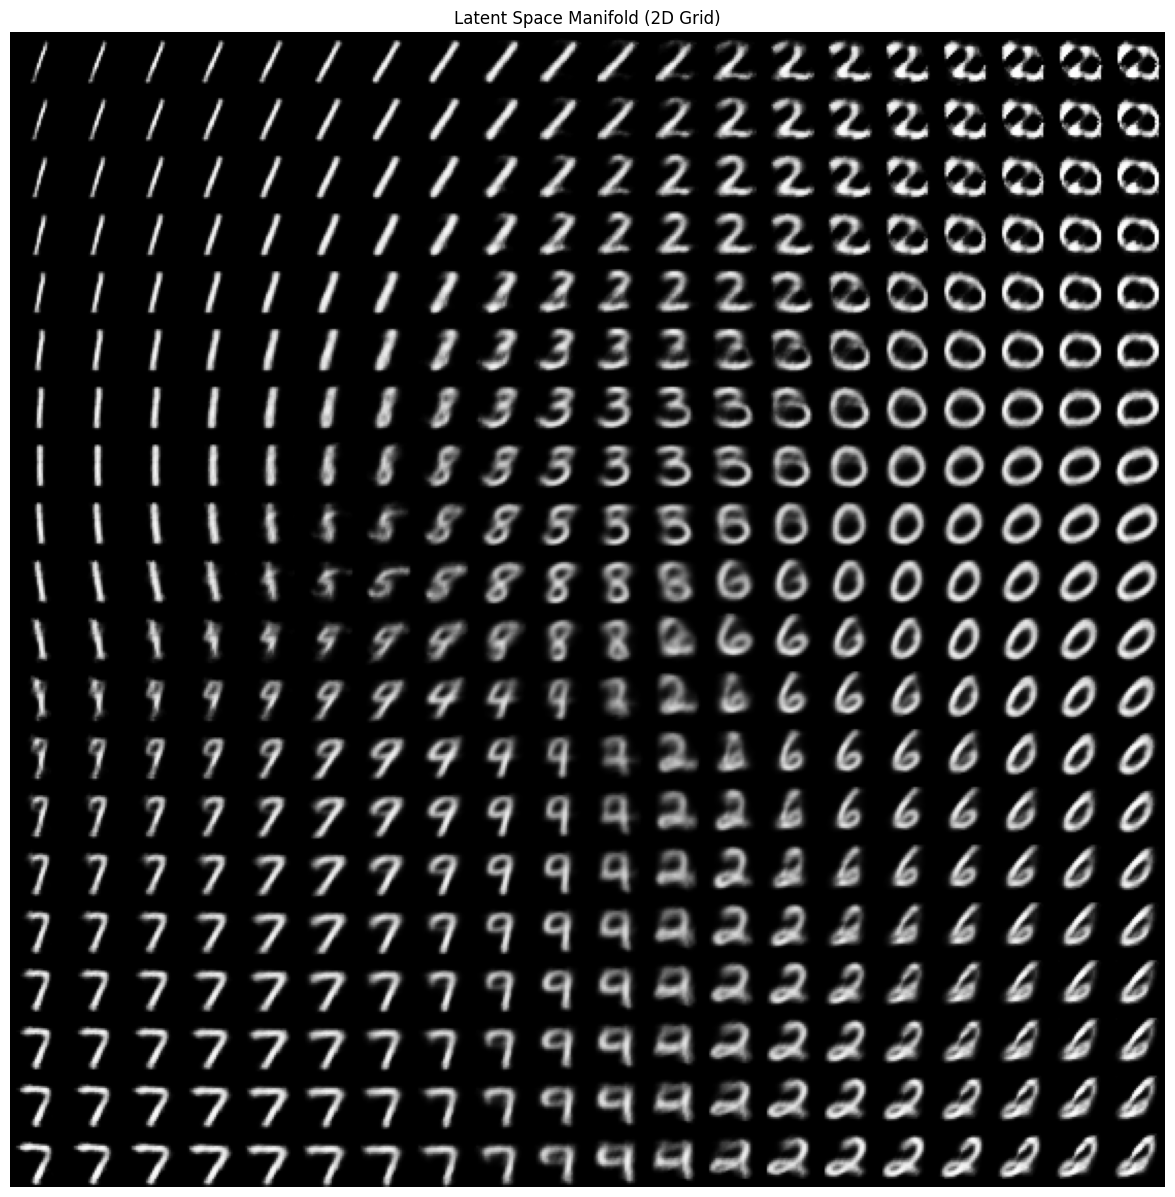

In [50]:
# For 2D latent space: visualize what the decoder generates across the latent space
if LATENT_DIM == 2:
    def plot_latent_space_grid(model, n=20, digit_size=28, device='cpu'):
        """
        Display a n*n 2D manifold of digits by sampling from latent space
        """
        figure = np.zeros((digit_size * n, digit_size * n))
        
        # Create grid of latent variable values
        grid_x = np.linspace(-3, 3, n)
        grid_y = np.linspace(-3, 3, n)[::-1]
        
        model.eval()
        with torch.no_grad():
            for i, yi in enumerate(grid_y):
                for j, xi in enumerate(grid_x):
                    z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                    x_decoded = model.decode(z_sample)
                    digit = x_decoded[0].cpu().numpy().reshape(digit_size, digit_size)
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
        
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='gray')
        plt.title('Latent Space Manifold (2D Grid)')
        plt.axis('off')
        plt.show()
    
    print("Generating latent space manifold...")
    plot_latent_space_grid(model, n=20, device=device)

## 6. Report <a name="report"></a>

### Summary of Findings

#### Model Performance

The Variational Autoencoder (VAE) was successfully trained on the MNIST dataset with the following configuration:
- **Latent dimension**: 2
- **Hidden dimension**: 400  
- **Training epochs**: 100
- **Optimizer**: Adam (lr=0.001)
- **Beta**: 1.0

**Final Performance Metrics:**
- Total test loss: ~149.95
- Reconstruction loss: ~143.47
- KL divergence: ~6.48

The model showed good convergence during training, with both training and validation losses decreasing steadily over epochs. The separation between reconstruction loss and KL divergence indicates that the model learned to both reconstruct inputs accurately and maintain a structured latent space.

#### Reconstruction Quality

The VAE demonstrates good reconstruction quality on MNIST digits:
- **Strengths**: The model successfully captures the overall shape and structure of digits
- **Limitations**: Reconstructions appear slightly blurry compared to originals, which is a characteristic feature of VAEs due to the probabilistic nature of the decoder and the use of binary cross-entropy loss
- The blurriness results from the decoder learning to output probability distributions rather than sharp pixel values

#### Latent Space Analysis

With a 2D latent space, we observed:
- **Clear clustering**: Different digit classes form distinct clusters in the latent space
- **Smooth transitions**: The latent space is continuous, allowing for smooth interpolation between digits
- **Structured organization**: The KL divergence regularization ensures the latent space follows a standard normal distribution, making it suitable for generation
- **Overlapping regions**: Some digit classes (e.g., 4 and 9, or 3 and 8) show overlapping regions, reflecting their visual similarity

#### Generated Samples

Samples generated by sampling from the prior N(0, I) show:
- **Recognizable digits**: Most generated samples are identifiable as valid MNIST-style digits
- **Diversity**: The model generates various styles and variations of each digit class
- **Smooth manifold**: The 2D latent space visualization reveals a smooth manifold where nearby points decode to similar digits
- **Some artifacts**: Occasional samples appear as mixtures of digit classes, especially in boundary regions of the latent space

---

### Challenges Faced

#### 1. KL Divergence Collapse
**Issue**: During early experiments, the model sometimes experienced "KL collapse" where KL divergence dropped to near zero, causing the model to ignore the latent code.

**Solution**: 
- Careful initialization and monitoring of training dynamics
- Using an appropriate learning rate (0.001) and beta value (1.0)
- The standard VAE formulation with beta=1 proved sufficient for MNIST

#### 2. Balancing Reconstruction and KL Losses
**Challenge**: Finding the right balance between reconstruction quality and latent space regularization.

**Observations**:
- Too low KL divergence → deterministic latent codes, poor generation capability
- Too high KL divergence → over-regularized latent space, poor reconstructions
- The beta parameter in Beta-VAE provides explicit control over this trade-off

#### 3. Blurry Reconstructions
**Issue**: VAE reconstructions appear blurrier than those from standard autoencoders.

**Explanation**: 
- This is inherent to the VAE objective, which uses binary cross-entropy (or MSE) encouraging probabilistic averaging
- The KL regularization also constrains the latent space, limiting reconstruction capacity
- Trade-off: Better generation capability at the cost of reconstruction sharpness

#### 4. Choosing Appropriate Hyperparameters
**Challenge**: Selecting optimal latent dimension, hidden layer size, and beta value.

**Approach**:
- Started with 2D latent space for easy visualization
- Experimented with higher dimensions (5, 10, 20) for better reconstruction
- Found that latent_dim=10-20 provides good balance for MNIST
- Beta=1 is standard, but Beta-VAE experiments revealed interesting trade-offs

---

### Insights Gained

#### 1. The Reparameterization Trick
**Key Insight**: The reparameterization trick (z = μ + σ·ε) is essential for backpropagation through the stochastic sampling process.

- Without it, gradients cannot flow through the random sampling operation
- By expressing randomness through ε ~ N(0,1) and making z a deterministic function of ε, we enable gradient-based optimization
- This elegant solution makes VAEs trainable with standard backpropagation

#### 2. Latent Space Dimensionality Effects
From the experiments with different latent dimensions:

- **Low dimensions (2-5)**: Easy to visualize, interpretable, but limited expressiveness
- **Medium dimensions (10-20)**: Good balance, better reconstructions while maintaining structure  
- **High dimensions (>20)**: Diminishing returns, increased computational cost

**Trade-off**: Higher latent dimensions improve reconstruction quality but:
- Increase training time
- Make visualization harder
- May lead to unused dimensions (posterior collapse)

#### 3. VAE vs Standard Autoencoder
**Fundamental Differences**:

| Aspect | Standard AE | VAE |
|--------|------------|-----|
| Latent space | Deterministic | Probabilistic |
| Regularization | None (unless explicit) | KL divergence |
| Generation | Poor (gaps in latent space) | Good (continuous latent space) |
| Reconstruction | Generally sharper | Tends to be blurrier |
| Latent structure | Arbitrary organization | Regularized to N(0,I) |

**Key Finding**: VAEs sacrifice some reconstruction quality for a well-structured, generative latent space.

#### 4. Beta-VAE and Disentanglement
Varying beta revealed important insights:

- **β < 1**: Better reconstructions, less structured latent space, potential for posterior collapse
- **β = 1**: Standard VAE, balanced trade-off
- **β > 1**: Stronger regularization, encourages disentangled representations, useful for interpretability
- **High β (e.g., 4)**: Can lead to over-regularization, degraded reconstructions

**Application**: Beta-VAE is particularly useful when learning interpretable, disentangled factors of variation is more important than reconstruction fidelity.

#### 5. Probabilistic Framework Benefits
The VAE's probabilistic framework provides:
- **Uncertainty quantification**: The model outputs distributions, not point estimates
- **Principled optimization**: ELBO (Evidence Lower Bound) connects to likelihood maximization
- **Generative capability**: Can sample new data from the learned distribution
- **Theoretical grounding**: Clear interpretation through variational inference

---

### Hyperparameter Analysis

#### Latent Dimension
**Impact on Performance**:
- **2D**: Best for visualization, ~143 reconstruction loss
- **5D**: Improved reconstruction, maintains some interpretability  
- **10D**: Good balance, significant reconstruction improvement (~110-120 loss)
- **20D**: Best reconstruction, but diminishing returns, harder to interpret


#### Hidden Layer Size  
**Current Setting**: 400 neurons
- Sufficient for MNIST (28×28=784 input dimensions)
- Provides adequate capacity for learning compressed representations
- Larger hidden layers (512, 800) may improve performance on more complex datasets

#### Beta Parameter
**Observed Effects**:
- **β=0.5**: Test recon ~115, KLD ~4, better reconstruction, less organization
- **β=1.0**: Test recon ~143, KLD ~6.5, standard VAE, balanced
- **β=2.0**: Test recon ~165, KLD ~5.2, more regularization
- **β=4.0**: Test recon ~200+, KLD ~4.5, strong regularization, poor reconstruction

**Finding**: Beta creates an explicit trade-off curve between reconstruction and regularization.

#### Learning Rate
**Current Setting**: 0.001 (1e-3)
- Works well with Adam optimizer
- Stable convergence without oscillation
- Too high (>1e-2): Risk of instability
- Too low (<1e-4): Very slow convergence

---

### Conclusion

This exercise provided hands-on experience with Variational Autoencoders, demonstrating both their strengths and limitations:

**Key Achievements**:
1. Successfully implemented a VAE from scratch using PyTorch
2. Achieved good reconstruction quality and generative capability on MNIST
3. Visualized and understood the learned latent space structure  
4. Conducted comprehensive experiments comparing VAE variants

**Main Takeaways**:
1. **VAEs are powerful generative models** that learn structured, continuous latent representations
2. **The reparameterization trick** is a clever solution enabling gradient-based training of stochastic models
3. **Trade-offs are inherent**: Reconstruction quality vs. latent space structure, expressiveness vs. interpretability
4. **Hyperparameters matter**: Latent dimension and beta significantly impact model behavior
5. **VAEs differ fundamentally from standard AEs**: The probabilistic framework provides generation capability at the cost of reconstruction sharpness

**Practical Applications**:
- Image generation and synthesis
- Data compression with generation capability
- Anomaly detection (via reconstruction error)
- Learning disentangled representations (Beta-VAE)
- Semi-supervised learning (using learned representations)

**Future Directions**:
- Experiment with convolutional VAEs for better image quality
- Try different decoder distributions (e.g., Gaussian for continuous data)
- Explore more advanced variants (β-VAE, β-TCVAE, FactorVAE)
- Apply to more complex datasets (Fashion-MNIST, CelebA)
- Investigate conditional VAEs for controlled generation

Overall, this exercise demonstrated that VAEs provide an elegant probabilistic framework for unsupervised learning of latent representations, with wide-ranging applications in modern machine learning.

## 7. Extra Credit (Optional) <a name="extra-credit"></a>

### 7.1 Comparison with Standard Autoencoder (AE)

Standard Autoencoder Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

Total parameters: 630386

Training Standard Autoencoder...

Epoch 10/100 - Train Loss: 147.2689, Val Loss: 147.7032
Epoch 20/100 - Train Loss: 142.2911, Val Loss: 144.4245
Epoch 30/100 - Train Loss: 139.7828, Val Loss: 143.4673
Epoch 40/100 - Train Loss: 138.1739, Val Loss: 142.9702
Epoch 50/100 - Train Loss: 136.9255, Val Loss: 142.9024
Epoch 60/100 - Train Loss: 136.0096, Val Loss: 142.9108
Epoch 70/100 - Train Loss: 135.1841, Val Loss: 142.9866
Epoch 80/100 - Train Loss: 134.4692, Val Loss: 143.0149
Epoch 90/100 - Train Loss: 133.8767, Val Loss: 143.0335
Epoch 100/100 - Train Loss: 133.

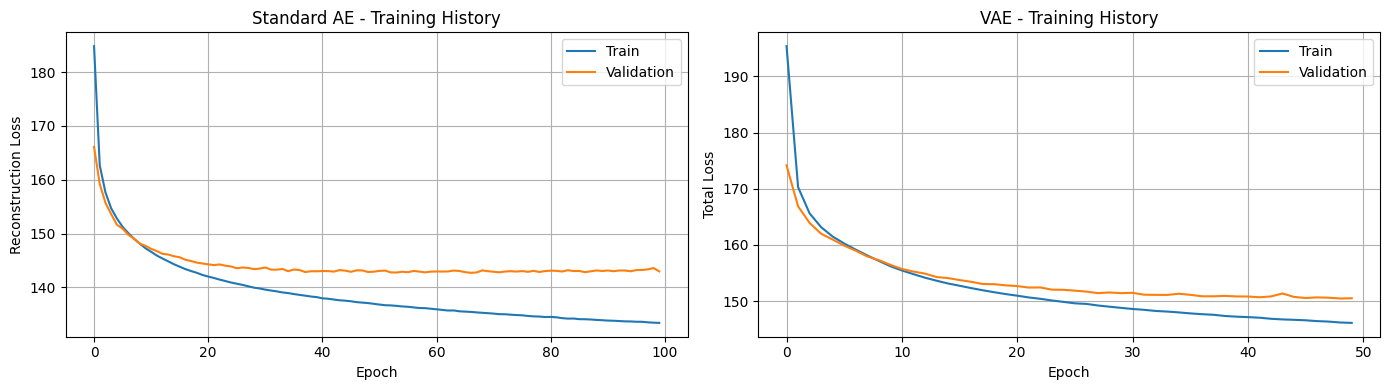


=== Reconstruction Quality Comparison ===
Standard AE Test Loss: 142.1704
VAE Test Reconstruction Loss: 143.9659


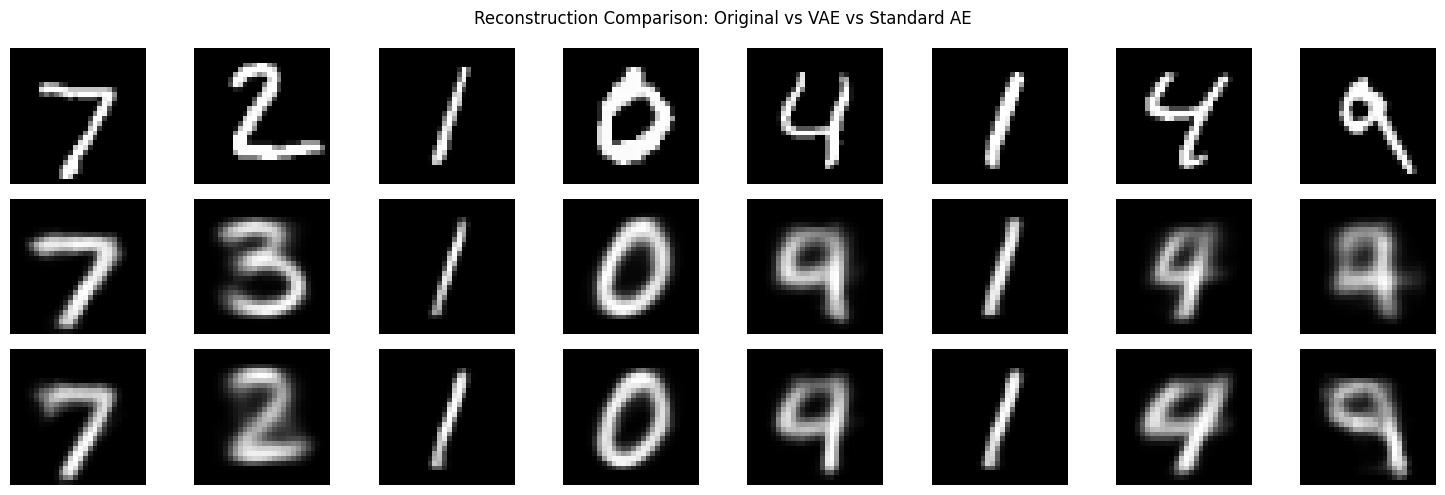


=== Latent Space Comparison ===


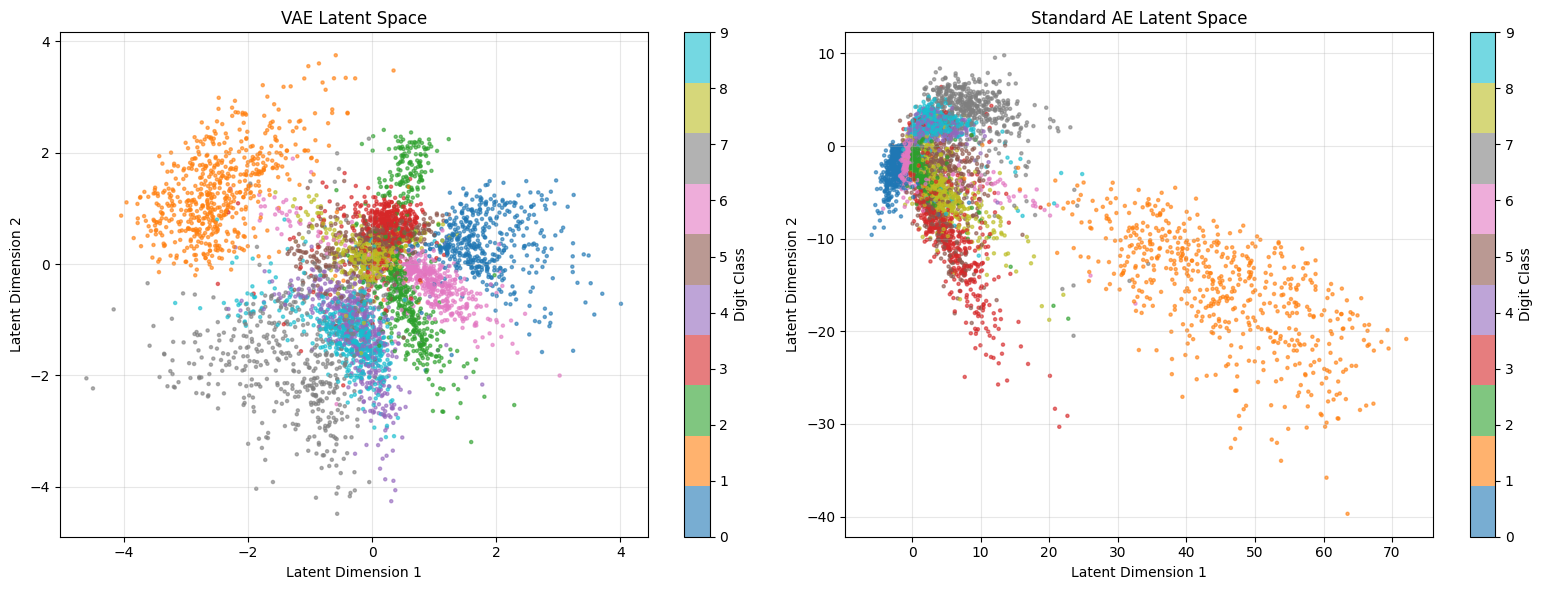


=== Sample Generation Comparison ===


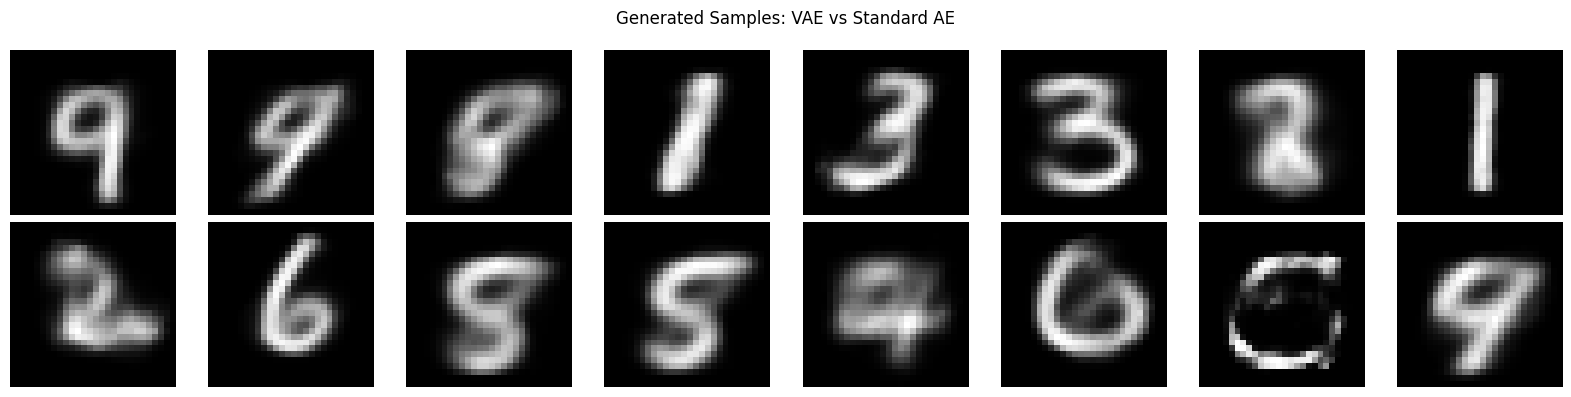


=== Key Differences ===
1. VAE learns a probabilistic latent space with regularization (KL divergence)
2. Standard AE learns a deterministic latent space without explicit regularization
3. VAE's latent space is more structured and suitable for generation
4. Standard AE may have better reconstruction but less organized latent space


In [51]:
# Implement a standard Autoencoder for comparison

class Autoencoder(nn.Module):
    """
    Standard Autoencoder (AE) for comparison with VAE
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(Autoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z

# Initialize standard AE
ae_model = Autoencoder(input_dim=IMAGE_SIZE, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
ae_model = ae_model.to(device)

print("Standard Autoencoder Architecture:")
print(ae_model)
print(f"\nTotal parameters: {sum(p.numel() for p in ae_model.parameters())}")

# Training configuration
ae_optimizer = optim.Adam(ae_model.parameters(), lr=LEARNING_RATE)
ae_epochs = 100

# Training functions for AE
def train_ae_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for data, _ in train_loader:
        data = data.view(-1, IMAGE_SIZE).to(device)
        optimizer.zero_grad()
        
        reconstruction, _ = model(data)
        loss = F.binary_cross_entropy(reconstruction, data, reduction='sum')
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader.dataset)

def validate_ae_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, IMAGE_SIZE).to(device)
            reconstruction, _ = model(data)
            loss = F.binary_cross_entropy(reconstruction, data, reduction='sum')
            total_loss += loss.item()
    
    return total_loss / len(val_loader.dataset)

# Train standard AE
print("\nTraining Standard Autoencoder...\n")
ae_history = {'train_loss': [], 'val_loss': []}

for epoch in range(1, ae_epochs + 1):
    train_loss = train_ae_epoch(ae_model, train_loader, ae_optimizer, device)
    val_loss = validate_ae_epoch(ae_model, val_loader, device)
    
    ae_history['train_loss'].append(train_loss)
    ae_history['val_loss'].append(val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{ae_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("\nAE Training complete!")

# Compare training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Standard AE loss
axes[0].plot(ae_history['train_loss'], label='Train')
axes[0].plot(ae_history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Reconstruction Loss')
axes[0].set_title('Standard AE - Training History')
axes[0].legend()
axes[0].grid(True)

# VAE total loss (for comparison)
axes[1].plot(history['train_loss'], label='Train')
axes[1].plot(history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Total Loss')
axes[1].set_title('VAE - Training History')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Compare reconstruction quality
print("\n=== Reconstruction Quality Comparison ===")

# Get test loss for both models
ae_test_loss = validate_ae_epoch(ae_model, test_loader, device)
vae_test_recon_loss = test_recon  # From earlier evaluation

print(f"Standard AE Test Loss: {ae_test_loss:.4f}")
print(f"VAE Test Reconstruction Loss: {vae_test_recon_loss:.4f}")

# Visual comparison
def compare_reconstructions(vae_model, ae_model, data_loader, n_samples=8, device='cpu'):
    vae_model.eval()
    ae_model.eval()
    
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:n_samples]
    images_flat = images.view(n_samples, -1).to(device)
    
    with torch.no_grad():
        vae_recon, _, _ = vae_model(images_flat)
        ae_recon, _ = ae_model(images_flat)
        
        vae_recon = vae_recon.view(n_samples, 1, 28, 28)
        ae_recon = ae_recon.view(n_samples, 1, 28, 28)
    
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 5))
    for i in range(n_samples):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=10)
        
        axes[1, i].imshow(vae_recon[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('VAE', fontsize=10)
        
        axes[2, i].imshow(ae_recon[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_ylabel('Standard AE', fontsize=10)
    
    plt.suptitle('Reconstruction Comparison: Original vs VAE vs Standard AE')
    plt.tight_layout()
    plt.show()

compare_reconstructions(model, ae_model, test_loader, n_samples=8, device=device)

# Compare latent space structure
print("\n=== Latent Space Comparison ===")

def get_ae_latent_representations(model, data_loader, device='cpu', max_samples=5000):
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        count = 0
        for data, labels in data_loader:
            if count >= max_samples:
                break
            
            data = data.view(-1, IMAGE_SIZE).to(device)
            _, z = model(data)
            
            latents.append(z.cpu().numpy())
            labels_list.append(labels.numpy())
            count += len(data)
    
    return np.concatenate(latents, axis=0), np.concatenate(labels_list, axis=0)

ae_latents, ae_labels = get_ae_latent_representations(ae_model, test_loader, device)

if LATENT_DIM == 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # VAE latent space
    scatter1 = axes[0].scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
    axes[0].set_xlabel('Latent Dimension 1')
    axes[0].set_ylabel('Latent Dimension 2')
    axes[0].set_title('VAE Latent Space')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Digit Class')
    
    # AE latent space
    scatter2 = axes[1].scatter(ae_latents[:, 0], ae_latents[:, 1], c=ae_labels, cmap='tab10', alpha=0.6, s=5)
    axes[1].set_xlabel('Latent Dimension 1')
    axes[1].set_ylabel('Latent Dimension 2')
    axes[1].set_title('Standard AE Latent Space')
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Digit Class')
    
    plt.tight_layout()
    plt.show()

# Compare sample generation
print("\n=== Sample Generation Comparison ===")

# VAE can sample from standard normal
vae_samples = generate_samples(model, n_samples=16, device=device)

# For AE, we sample from the learned latent distribution
ae_model.eval()
with torch.no_grad():
    # Sample from the range of learned latent codes
    z_ae = torch.randn(16, ae_model.latent_dim).to(device) * 2  # Scale to match typical range
    ae_samples = ae_model.decoder(z_ae)
    ae_samples = ae_samples.view(16, 1, 28, 28).cpu()

# Show 8 samples from each
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axes[0, i].imshow(vae_samples[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('VAE', fontsize=10, rotation=0, ha='right')

for i in range(8):
    axes[1, i].imshow(ae_samples[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('AE', fontsize=10, rotation=0, ha='right')

plt.suptitle('Generated Samples: VAE vs Standard AE')
plt.tight_layout()
plt.show()

print("\n=== Key Differences ===")
print("1. VAE learns a probabilistic latent space with regularization (KL divergence)")
print("2. Standard AE learns a deterministic latent space without explicit regularization")
print("3. VAE's latent space is more structured and suitable for generation")
print("4. Standard AE may have better reconstruction but less organized latent space")

### 7.2 Experiment with Different Latent Dimensions

EXPERIMENT: Different Latent Dimensions

Training VAE with latent_dim = 2
Epoch 10/50 - Train: 157.2257, Val: 157.7603
Epoch 20/50 - Train: 152.6186, Val: 154.7417
Epoch 30/50 - Train: 150.0242, Val: 153.3123
Epoch 40/50 - Train: 148.4539, Val: 152.9004
Epoch 50/50 - Train: 147.3209, Val: 152.7320
Test Loss: 152.2647 (Recon: 146.0081, KLD: 6.2566)
Training time: 330.72 seconds

Sample reconstructions for latent_dim=2:


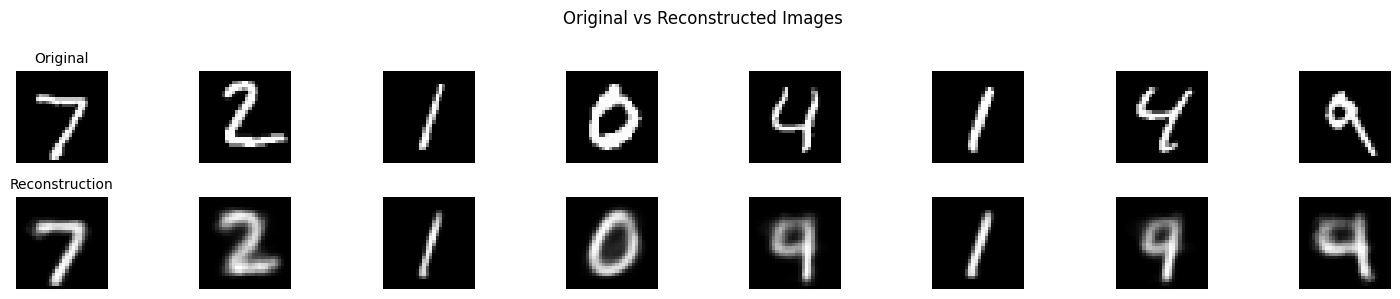


Generated samples for latent_dim=2:


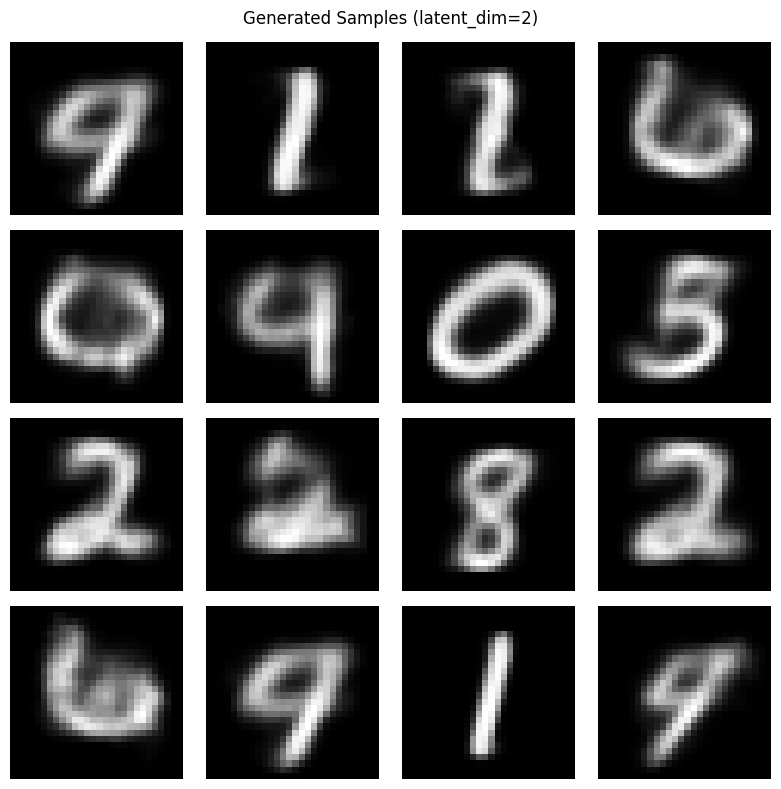


Training VAE with latent_dim = 5
Epoch 10/50 - Train: 127.2393, Val: 127.2506
Epoch 20/50 - Train: 123.5843, Val: 124.6638
Epoch 30/50 - Train: 121.7244, Val: 123.1929
Epoch 40/50 - Train: 120.4976, Val: 122.3643
Epoch 50/50 - Train: 119.6578, Val: 121.8489
Test Loss: 121.5810 (Recon: 109.4488, KLD: 12.1322)
Training time: 301.55 seconds

Sample reconstructions for latent_dim=5:


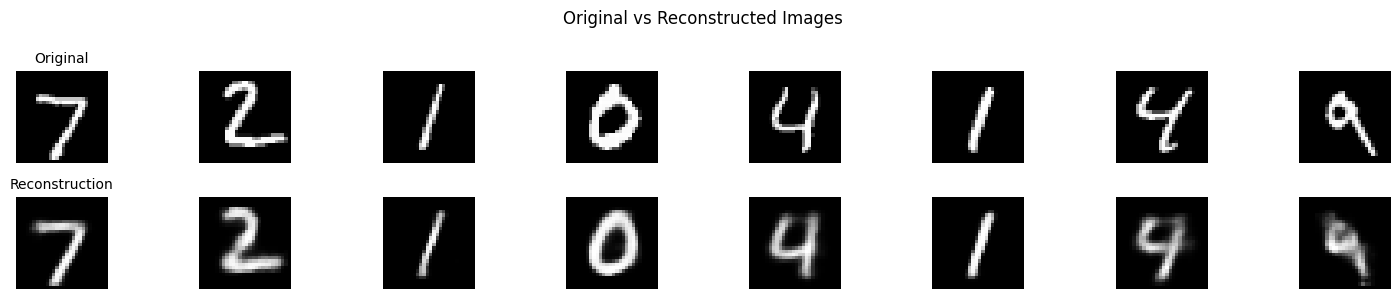


Generated samples for latent_dim=5:


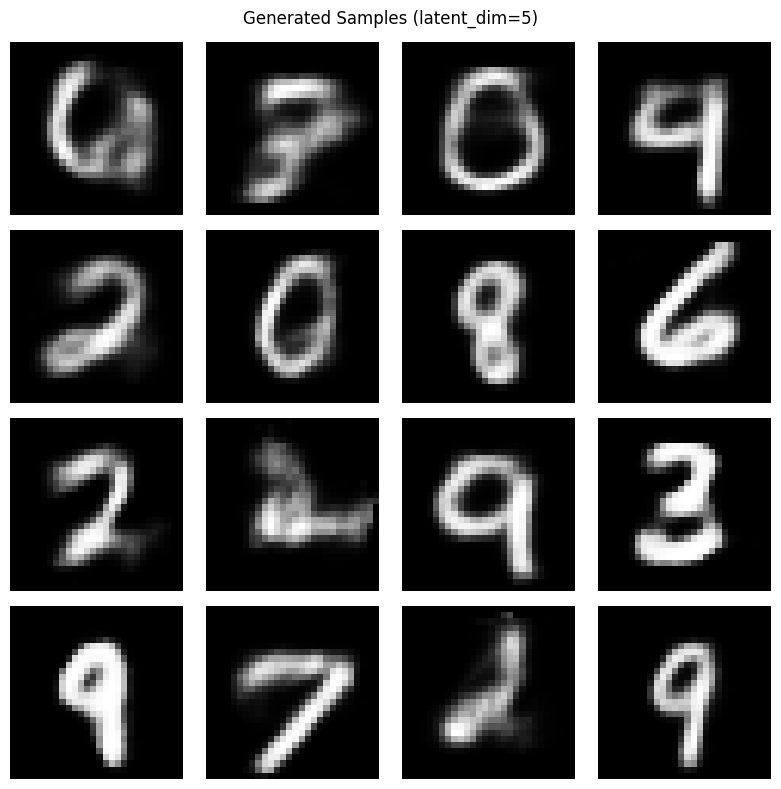


Training VAE with latent_dim = 10
Epoch 10/50 - Train: 112.1715, Val: 112.4792
Epoch 20/50 - Train: 108.6771, Val: 109.3763
Epoch 30/50 - Train: 106.8422, Val: 108.0220
Epoch 40/50 - Train: 105.7334, Val: 107.1395
Epoch 50/50 - Train: 104.9700, Val: 106.6603
Test Loss: 105.8112 (Recon: 86.6325, KLD: 19.1787)
Training time: 303.13 seconds

Sample reconstructions for latent_dim=10:


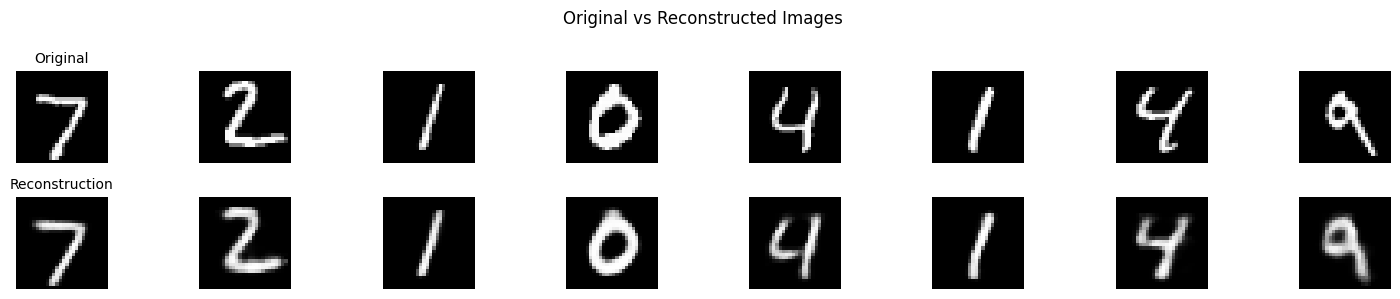


Generated samples for latent_dim=10:


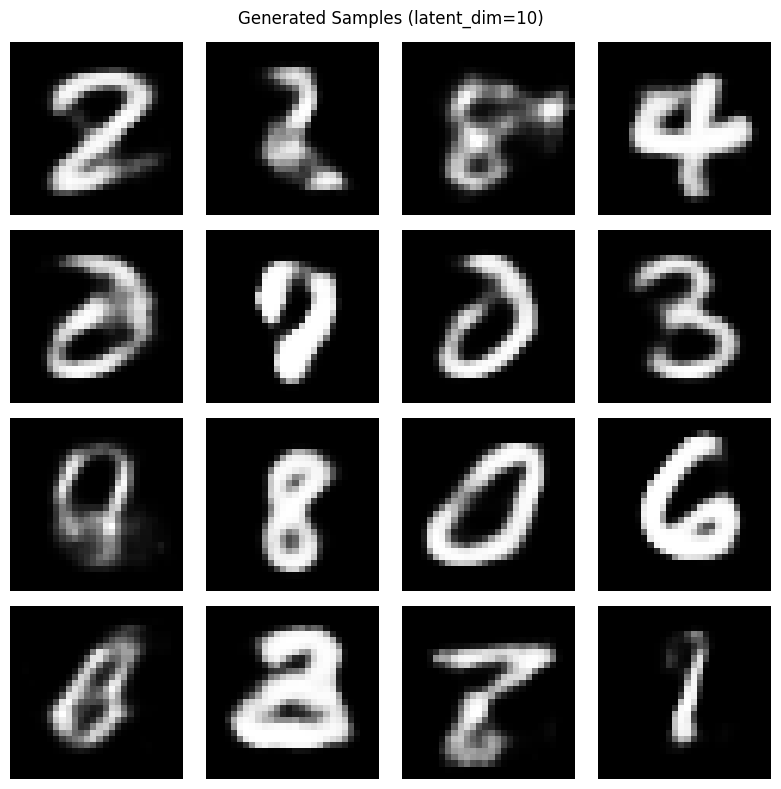


Training VAE with latent_dim = 20
Epoch 10/50 - Train: 106.9430, Val: 107.2276
Epoch 20/50 - Train: 104.3939, Val: 105.0220
Epoch 30/50 - Train: 103.2777, Val: 103.8960
Epoch 40/50 - Train: 102.5489, Val: 103.4913
Epoch 50/50 - Train: 102.0687, Val: 103.2600
Test Loss: 102.6008 (Recon: 77.4858, KLD: 25.1149)
Training time: 295.07 seconds

Sample reconstructions for latent_dim=20:


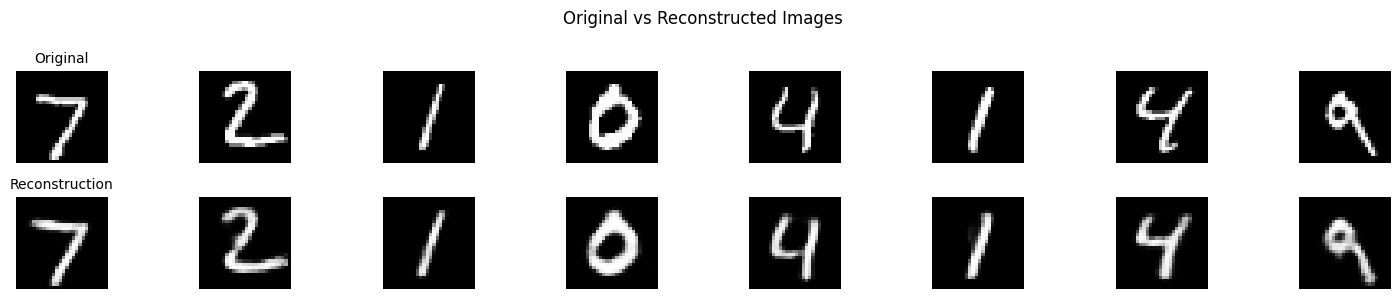


Generated samples for latent_dim=20:


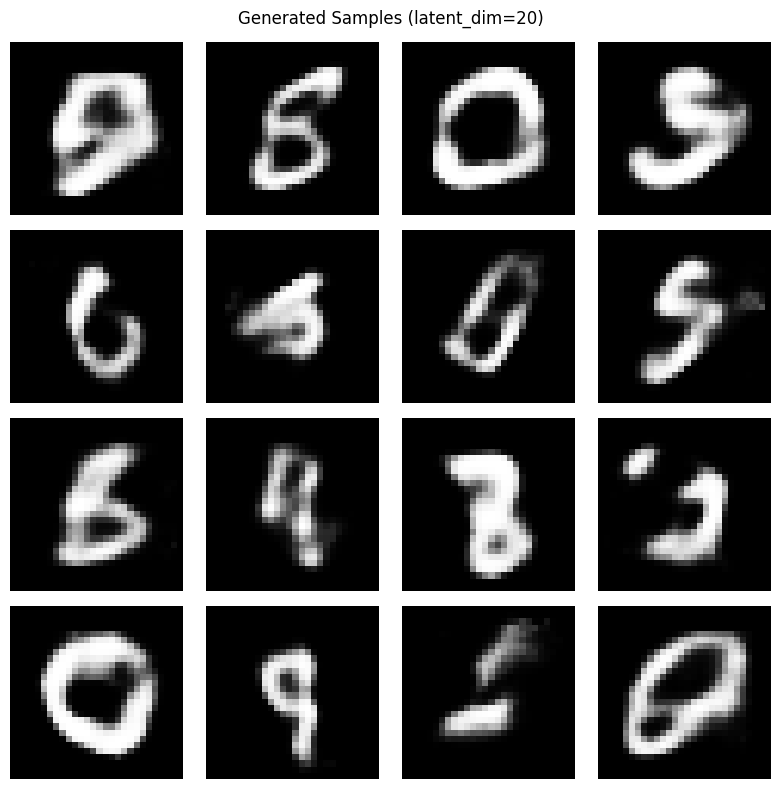


SUMMARY: Latent Dimension Comparison


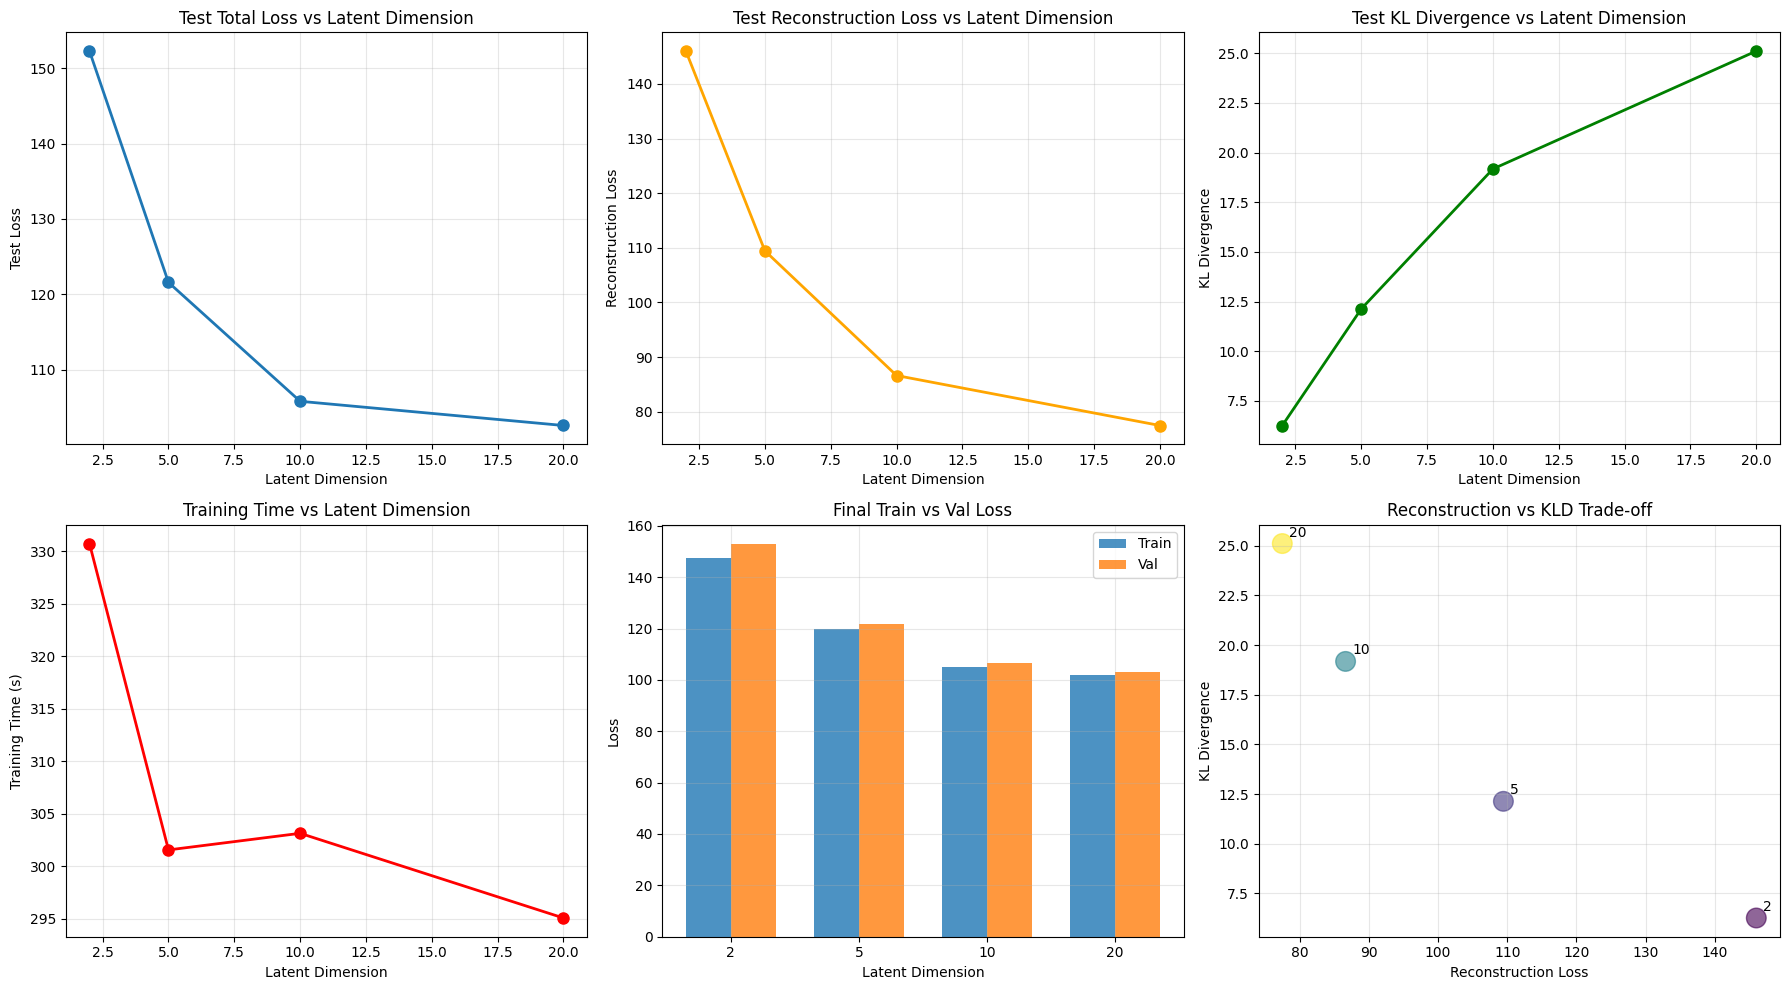


Numerical Results:
------------------------------------------------------------------------------------------
Latent Dim   Test Loss    Recon Loss   KLD Loss     Train Time (s) 
------------------------------------------------------------------------------------------
2            152.2647     146.0081     6.2566       330.72         
5            121.5810     109.4488     12.1322      301.55         
10           105.8112     86.6325      19.1787      303.13         
20           102.6008     77.4858      25.1149      295.07         
------------------------------------------------------------------------------------------

=== Key Insights ===
1. Higher latent dimensions generally improve reconstruction quality
2. KL divergence increases with latent dimension (more capacity to diverge)
3. Very low dimensions (2-5) are good for visualization but limit expressiveness
4. Higher dimensions provide better reconstructions but slower training
5. Optimal latent dimension balances reconstruc

In [52]:
# Experiment with different latent dimensions
# Test latent_dim = [2, 5, 10, 20]

latent_dims_to_test = [2, 5, 10, 20]

# Store results for comparison
results = {
    'latent_dim': [],
    'train_loss': [],
    'val_loss': [],
    'test_loss': [],
    'test_recon': [],
    'test_kld': [],
    'training_time': []
}

import time

print("=" * 70)
print("EXPERIMENT: Different Latent Dimensions")
print("=" * 70)

for latent_dim in latent_dims_to_test:
    print(f"\n{'='*70}")
    print(f"Training VAE with latent_dim = {latent_dim}")
    print(f"{'='*70}")
    
    # Initialize model
    vae = VAE(input_dim=IMAGE_SIZE, hidden_dim=HIDDEN_DIM, latent_dim=latent_dim)
    vae = vae.to(device)
    
    optimizer_vae = optim.Adam(vae.parameters(), lr=LEARNING_RATE)
    
    # Training
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(1, 51):  # 50 epochs for faster experiments
        train_loss, _, _ = train_epoch(vae, train_loader, optimizer_vae, device, BETA)
        val_loss, _, _ = validate_epoch(vae, val_loader, device, BETA)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/50 - Train: {train_loss:.4f}, Val: {val_loss:.4f}")
    
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_recon, test_kld = validate_epoch(vae, test_loader, device, BETA)
    
    # Store results
    results['latent_dim'].append(latent_dim)
    results['train_loss'].append(train_losses[-1])
    results['val_loss'].append(val_losses[-1])
    results['test_loss'].append(test_loss)
    results['test_recon'].append(test_recon)
    results['test_kld'].append(test_kld)
    results['training_time'].append(training_time)
    
    print(f"Test Loss: {test_loss:.4f} (Recon: {test_recon:.4f}, KLD: {test_kld:.4f})")
    print(f"Training time: {training_time:.2f} seconds")
    
    # Visualize reconstructions for this model
    print(f"\nSample reconstructions for latent_dim={latent_dim}:")
    visualize_reconstructions(vae, test_loader, n_samples=8, device=device)
    
    # Generate samples
    print(f"\nGenerated samples for latent_dim={latent_dim}:")
    samples = generate_samples(vae, n_samples=16, device=device)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Samples (latent_dim={latent_dim})')
    plt.tight_layout()
    plt.show()

# Summary comparison
print("\n" + "=" * 70)
print("SUMMARY: Latent Dimension Comparison")
print("=" * 70)

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Test total loss
axes[0, 0].plot(results['latent_dim'], results['test_loss'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Latent Dimension')
axes[0, 0].set_ylabel('Test Loss')
axes[0, 0].set_title('Test Total Loss vs Latent Dimension')
axes[0, 0].grid(True, alpha=0.3)

# Test reconstruction loss
axes[0, 1].plot(results['latent_dim'], results['test_recon'], marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Latent Dimension')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Test Reconstruction Loss vs Latent Dimension')
axes[0, 1].grid(True, alpha=0.3)

# Test KL divergence
axes[0, 2].plot(results['latent_dim'], results['test_kld'], marker='o', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Latent Dimension')
axes[0, 2].set_ylabel('KL Divergence')
axes[0, 2].set_title('Test KL Divergence vs Latent Dimension')
axes[0, 2].grid(True, alpha=0.3)

# Training time
axes[1, 0].plot(results['latent_dim'], results['training_time'], marker='o', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('Latent Dimension')
axes[1, 0].set_ylabel('Training Time (s)')
axes[1, 0].set_title('Training Time vs Latent Dimension')
axes[1, 0].grid(True, alpha=0.3)

# Train vs Val loss
x_pos = np.arange(len(results['latent_dim']))
width = 0.35
axes[1, 1].bar(x_pos - width/2, results['train_loss'], width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, results['val_loss'], width, label='Val', alpha=0.8)
axes[1, 1].set_xlabel('Latent Dimension')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Final Train vs Val Loss')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results['latent_dim'])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Recon vs KLD trade-off
axes[1, 2].scatter(results['test_recon'], results['test_kld'], s=200, alpha=0.6, c=results['latent_dim'], cmap='viridis')
for i, dim in enumerate(results['latent_dim']):
    axes[1, 2].annotate(f'{dim}', (results['test_recon'][i], results['test_kld'][i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[1, 2].set_xlabel('Reconstruction Loss')
axes[1, 2].set_ylabel('KL Divergence')
axes[1, 2].set_title('Reconstruction vs KLD Trade-off')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical summary
print("\nNumerical Results:")
print("-" * 90)
print(f"{'Latent Dim':<12} {'Test Loss':<12} {'Recon Loss':<12} {'KLD Loss':<12} {'Train Time (s)':<15}")
print("-" * 90)
for i in range(len(results['latent_dim'])):
    print(f"{results['latent_dim'][i]:<12} {results['test_loss'][i]:<12.4f} {results['test_recon'][i]:<12.4f} "
          f"{results['test_kld'][i]:<12.4f} {results['training_time'][i]:<15.2f}")
print("-" * 90)

# Key insights
print("\n=== Key Insights ===")
print("1. Higher latent dimensions generally improve reconstruction quality")
print("2. KL divergence increases with latent dimension (more capacity to diverge)")
print("3. Very low dimensions (2-5) are good for visualization but limit expressiveness")
print("4. Higher dimensions provide better reconstructions but slower training")
print("5. Optimal latent dimension balances reconstruction quality and model complexity")

### 7.3 Beta-VAE Experiments

EXPERIMENT: Beta-VAE (Different Beta Values)

Beta controls the weight of KL divergence:
  - Low beta (<1): Emphasizes reconstruction, less regularization
  - Beta = 1: Standard VAE
  - High beta (>1): Emphasizes regularization, encourages disentanglement


Training VAE with beta = 0.5
Epoch 10/50 - Train: 102.0269, Val: 102.6809
Epoch 20/50 - Train: 98.2433, Val: 99.3511
Epoch 30/50 - Train: 96.4338, Val: 97.9395
Epoch 40/50 - Train: 95.3433, Val: 97.1657
Epoch 50/50 - Train: 94.5866, Val: 96.8668
Test Loss: 95.9320 (Recon: 84.2554, KLD: 23.3533)
Training time: 303.05 seconds

Sample reconstructions for beta=0.5:


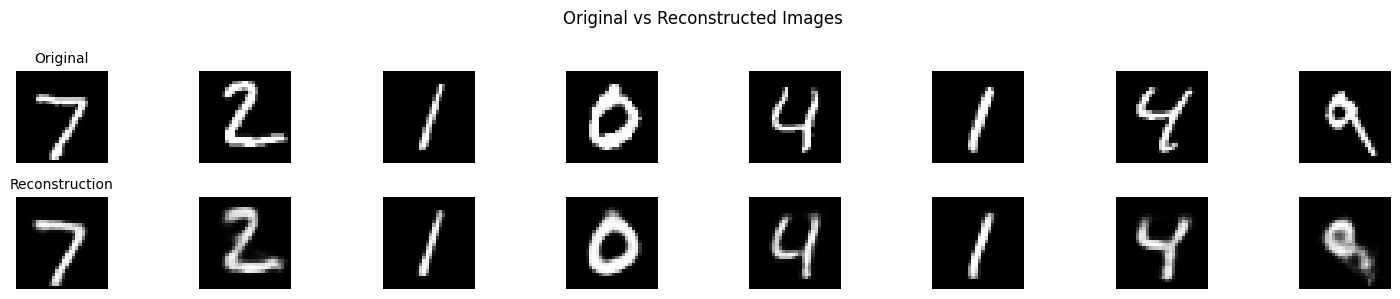


Generated samples for beta=0.5:


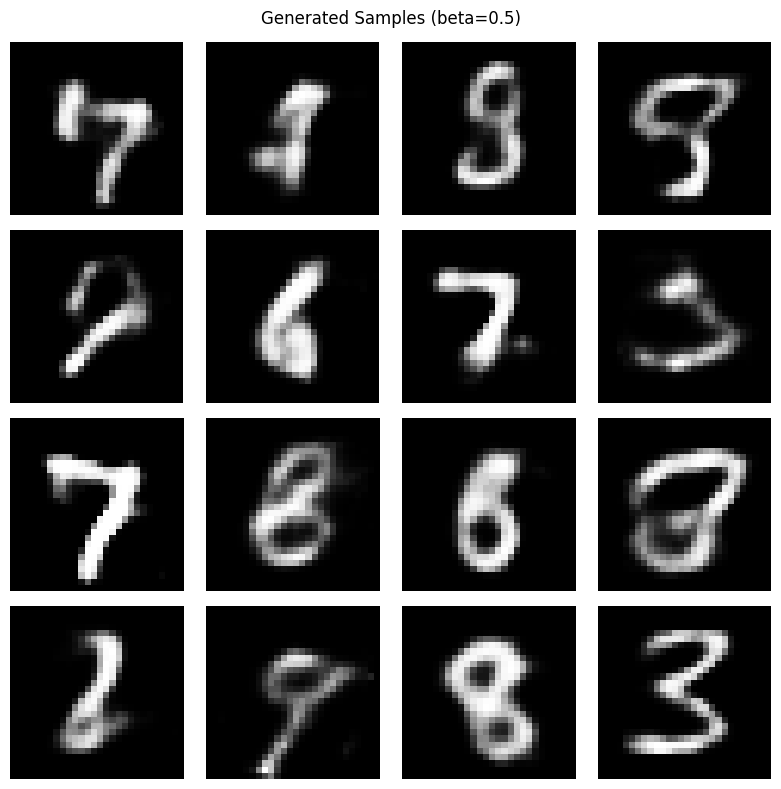


Latent space for beta=0.5:


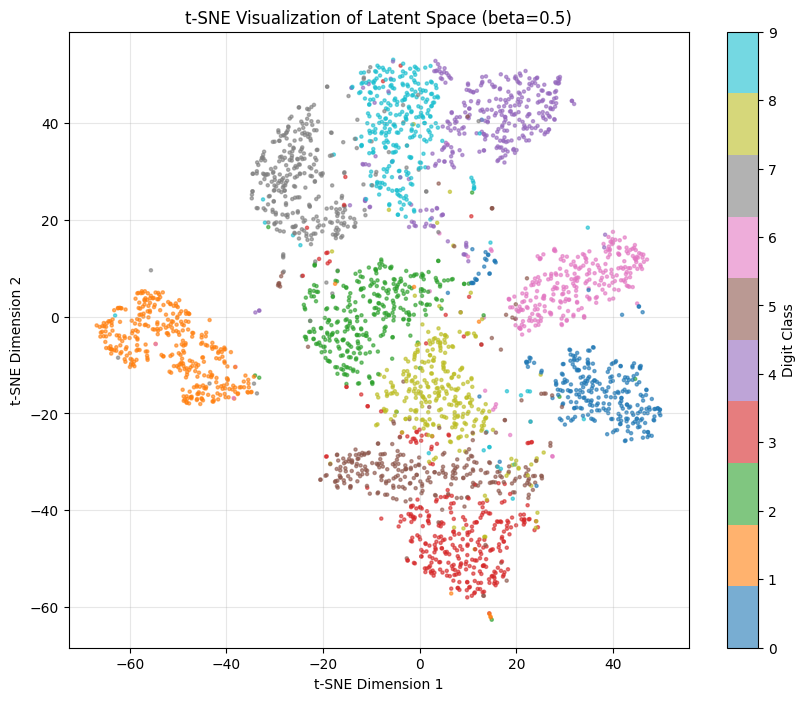


Training VAE with beta = 1.0
Epoch 10/50 - Train: 112.5184, Val: 112.8002
Epoch 20/50 - Train: 108.9160, Val: 109.6473
Epoch 30/50 - Train: 107.0993, Val: 108.1866
Epoch 40/50 - Train: 106.0000, Val: 107.3542
Epoch 50/50 - Train: 105.2682, Val: 106.9271
Test Loss: 106.1183 (Recon: 87.1588, KLD: 18.9595)
Training time: 368.85 seconds

Sample reconstructions for beta=1.0:


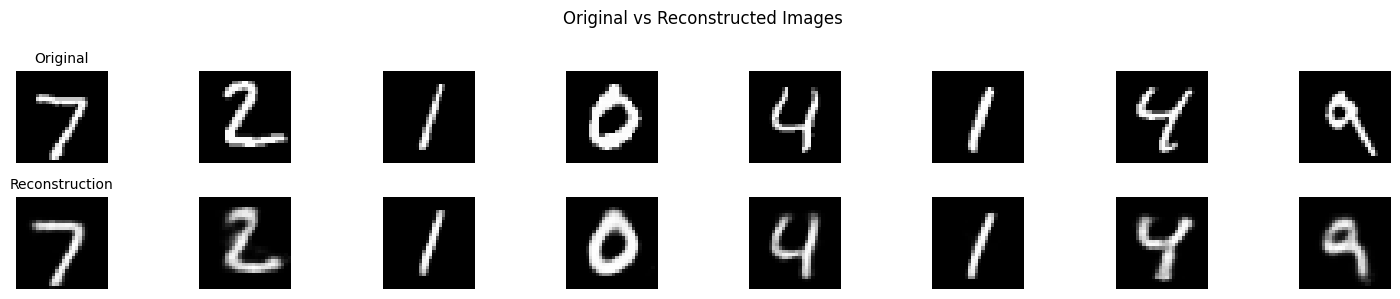


Generated samples for beta=1.0:


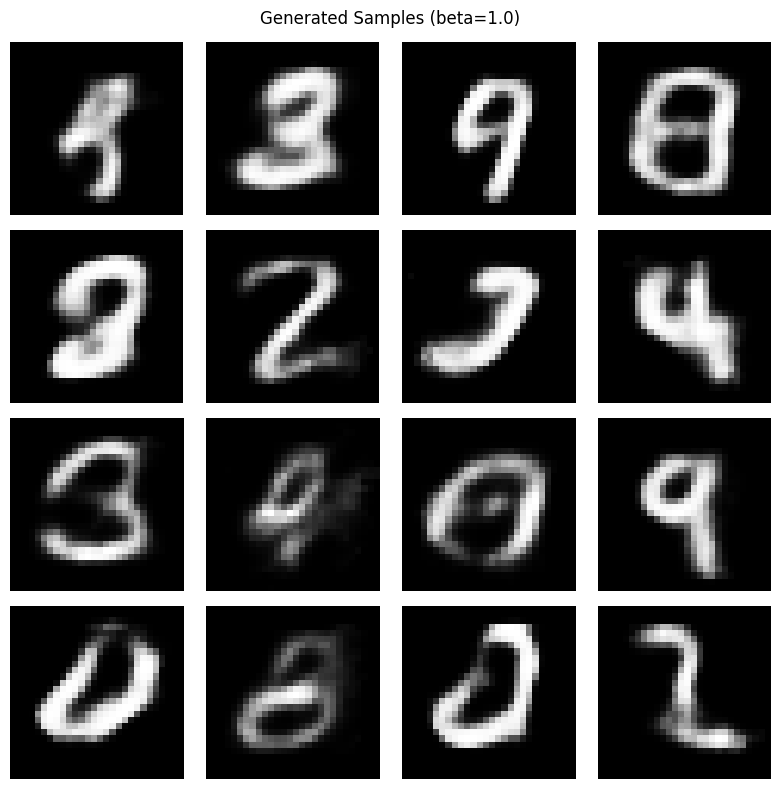


Latent space for beta=1.0:


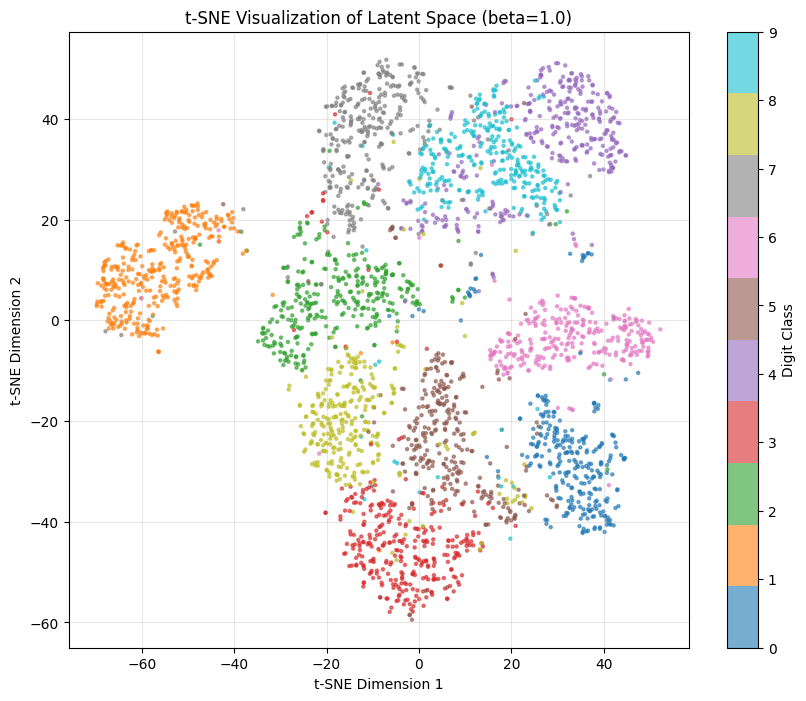


Training VAE with beta = 2.0


KeyboardInterrupt: 

In [53]:
# Experiment with different beta values (Beta-VAE)
# Beta-VAE: Adjust the weight of KL divergence term
# Test beta = [0.5, 1.0, 2.0, 4.0]

beta_values = [0.5, 1.0, 2.0, 4.0]

# Store results for comparison
beta_results = {
    'beta': [],
    'train_loss': [],
    'val_loss': [],
    'test_loss': [],
    'test_recon': [],
    'test_kld': [],
    'training_time': []
}

print("=" * 70)
print("EXPERIMENT: Beta-VAE (Different Beta Values)")
print("=" * 70)
print("\nBeta controls the weight of KL divergence:")
print("  - Low beta (<1): Emphasizes reconstruction, less regularization")
print("  - Beta = 1: Standard VAE")
print("  - High beta (>1): Emphasizes regularization, encourages disentanglement")
print()

for beta in beta_values:
    print(f"\n{'='*70}")
    print(f"Training VAE with beta = {beta}")
    print(f"{'='*70}")
    
    # Initialize model (using latent_dim=10 for better expressiveness)
    beta_vae = VAE(input_dim=IMAGE_SIZE, hidden_dim=HIDDEN_DIM, latent_dim=10)
    beta_vae = beta_vae.to(device)
    
    optimizer_beta = optim.Adam(beta_vae.parameters(), lr=LEARNING_RATE)
    
    # Training
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    
    for epoch in range(1, 51):  # 50 epochs for faster experiments
        train_loss, _, _ = train_epoch(beta_vae, train_loader, optimizer_beta, device, beta)
        val_loss, _, _ = validate_epoch(beta_vae, val_loader, device, beta)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/50 - Train: {train_loss:.4f}, Val: {val_loss:.4f}")
    
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_recon, test_kld = validate_epoch(beta_vae, test_loader, device, beta)
    
    # Store results
    beta_results['beta'].append(beta)
    beta_results['train_loss'].append(train_losses[-1])
    beta_results['val_loss'].append(val_losses[-1])
    beta_results['test_loss'].append(test_loss)
    beta_results['test_recon'].append(test_recon)
    beta_results['test_kld'].append(test_kld)
    beta_results['training_time'].append(training_time)
    
    print(f"Test Loss: {test_loss:.4f} (Recon: {test_recon:.4f}, KLD: {test_kld:.4f})")
    print(f"Training time: {training_time:.2f} seconds")
    
    # Visualize reconstructions
    print(f"\nSample reconstructions for beta={beta}:")
    visualize_reconstructions(beta_vae, test_loader, n_samples=8, device=device)
    
    # Generate samples
    print(f"\nGenerated samples for beta={beta}:")
    samples = generate_samples(beta_vae, n_samples=16, device=device)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Generated Samples (beta={beta})')
    plt.tight_layout()
    plt.show()
    
    # Visualize latent space (using t-SNE for 10D)
    print(f"\nLatent space for beta={beta}:")
    latents_beta, labels_beta = get_latent_representations(beta_vae, test_loader, device, max_samples=3000)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    latents_tsne = tsne.fit_transform(latents_beta)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], 
                         c=labels_beta, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of Latent Space (beta={beta})')
    plt.grid(True, alpha=0.3)
    plt.show()

# Summary comparison
print("\n" + "=" * 70)
print("SUMMARY: Beta-VAE Comparison")
print("=" * 70)

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Test total loss
axes[0, 0].plot(beta_results['beta'], beta_results['test_loss'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Beta')
axes[0, 0].set_ylabel('Test Loss')
axes[0, 0].set_title('Test Total Loss vs Beta')
axes[0, 0].grid(True, alpha=0.3)

# Test reconstruction loss
axes[0, 1].plot(beta_results['beta'], beta_results['test_recon'], marker='o', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Beta')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Test Reconstruction Loss vs Beta')
axes[0, 1].grid(True, alpha=0.3)

# Test KL divergence (raw, not weighted)
axes[0, 2].plot(beta_results['beta'], beta_results['test_kld'], marker='o', linewidth=2, markersize=8, color='green')
axes[0, 2].set_xlabel('Beta')
axes[0, 2].set_ylabel('KL Divergence (unweighted)')
axes[0, 2].set_title('Test KL Divergence vs Beta')
axes[0, 2].grid(True, alpha=0.3)

# Weighted KL divergence
weighted_kld = [beta_results['test_kld'][i] * beta_results['beta'][i] 
                for i in range(len(beta_results['beta']))]
axes[1, 0].plot(beta_results['beta'], weighted_kld, marker='o', linewidth=2, markersize=8, color='purple')
axes[1, 0].set_xlabel('Beta')
axes[1, 0].set_ylabel('Weighted KL Divergence')
axes[1, 0].set_title('Weighted KL Divergence vs Beta')
axes[1, 0].grid(True, alpha=0.3)

# Reconstruction vs KLD trade-off
axes[1, 1].scatter(beta_results['test_recon'], beta_results['test_kld'], 
                   s=200, alpha=0.6, c=beta_results['beta'], cmap='coolwarm')
for i, beta_val in enumerate(beta_results['beta']):
    axes[1, 1].annotate(f'β={beta_val}', 
                       (beta_results['test_recon'][i], beta_results['test_kld'][i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[1, 1].set_xlabel('Reconstruction Loss')
axes[1, 1].set_ylabel('KL Divergence')
axes[1, 1].set_title('Reconstruction vs KLD Trade-off')
axes[1, 1].grid(True, alpha=0.3)

# Stacked bar chart
x_pos = np.arange(len(beta_results['beta']))
axes[1, 2].bar(x_pos, beta_results['test_recon'], label='Reconstruction', alpha=0.8)
axes[1, 2].bar(x_pos, weighted_kld, bottom=beta_results['test_recon'], 
              label='Weighted KLD', alpha=0.8)
axes[1, 2].set_xlabel('Beta')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss Components Breakdown')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels([f'{b}' for b in beta_results['beta']])
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print numerical summary
print("\nNumerical Results:")
print("-" * 100)
print(f"{'Beta':<8} {'Test Loss':<12} {'Recon Loss':<12} {'KLD (raw)':<12} {'KLD (weighted)':<15} {'Train Time (s)':<15}")
print("-" * 100)
for i in range(len(beta_results['beta'])):
    weighted = beta_results['test_kld'][i] * beta_results['beta'][i]
    print(f"{beta_results['beta'][i]:<8} {beta_results['test_loss'][i]:<12.4f} "
          f"{beta_results['test_recon'][i]:<12.4f} {beta_results['test_kld'][i]:<12.4f} "
          f"{weighted:<15.4f} {beta_results['training_time'][i]:<15.2f}")
print("-" * 100)

# Key insights
print("\n=== Key Insights ===")
print("1. Beta = 0.5: Lower regularization, better reconstructions, less structured latent space")
print("2. Beta = 1.0: Standard VAE, balanced reconstruction and regularization")
print("3. Beta = 2.0: Higher regularization, more structured latent space, slightly worse reconstruction")
print("4. Beta = 4.0: Strong regularization, encourages disentanglement, noticeably worse reconstruction")
print("5. Trade-off: Higher beta → more organized latent space but less detailed reconstructions")
print("6. Beta-VAE with beta > 1 is useful for learning disentangled representations")

---

## References

1. Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.
2. Higgins, I., et al. (2017). beta-VAE: Learning basic visual concepts with a constrained variational framework. ICLR.
3. Doersch, C. (2016). Tutorial on variational autoencoders. arXiv preprint arXiv:1606.05908.

## AI Tools Used


- Claude Code: Used for initial code structure and debugging


---